<a href="https://colab.research.google.com/github/Jazzy-cats/AstraZenecaHackathon/blob/master/notebooks/AstraZeneca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget --header="Host: doc-0o-28-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9,sv-SE;q=0.8,sv;q=0.7" --header="Referer: https://drive.google.com/" --header="Cookie: AUTH_ok9rrm4pjcc68bmlnqgq80f5qppan9gm_nonce=icje3ro9qe6bs; _ga=GA1.2.143796104.1581334352" --header="Connection: keep-alive" "https://doc-0o-28-docs.googleusercontent.com/docs/securesc/7jciohj15joacnojebhvm4tlst22e35v/r12sff2sjv4i1j9b4jjsg2cro8hsvv9p/1601940750000/10812134156410604427/04059180890801963671/1gZh9AWYc_q8Yh4ZtVTzcl-gI5OUk3cm9?e=download&authuser=0&nonce=icje3ro9qe6bs&user=04059180890801963671&hash=roour1p4o1n0c34rfbjmll5u0lkt3bap" -c -O 'images_for_preview.zip'

--2020-10-06 07:21:07--  https://doc-0o-28-docs.googleusercontent.com/docs/securesc/7jciohj15joacnojebhvm4tlst22e35v/r12sff2sjv4i1j9b4jjsg2cro8hsvv9p/1601940750000/10812134156410604427/04059180890801963671/1gZh9AWYc_q8Yh4ZtVTzcl-gI5OUk3cm9?e=download&authuser=0&nonce=icje3ro9qe6bs&user=04059180890801963671&hash=roour1p4o1n0c34rfbjmll5u0lkt3bap
Resolving doc-0o-28-docs.googleusercontent.com (doc-0o-28-docs.googleusercontent.com)... 74.125.197.132, 2607:f8b0:400e:c03::84
Connecting to doc-0o-28-docs.googleusercontent.com (doc-0o-28-docs.googleusercontent.com)|74.125.197.132|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2020-10-06 07:21:07 ERROR 403: Forbidden.



In [ ]:
!unzip images_for_preview.zip

Archive:  images_for_preview.zip
replace images_for_preview/20x images/input/AssayPlate_Greiner_#655090_D04_T0001F006L01A04Z01C04.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
!git clone https://github.com/Jazzy-cats/AstraZenecaHackathon.git

Cloning into 'AstraZenecaHackathon'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 72 (delta 1), reused 6 (delta 1), pack-reused 65
Unpacking objects: 100% (72/72), done.
Checking out files: 100% (49/49), done.


In [4]:
!cp -r /content/AstraZenecaHackathon/images_for_preview /content/

In [5]:
!pip install -U albumentations

     |████████████████████████████████| 122kB 4.6MB/s 
     |████████████████████████████████| 952kB 8.6MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp36-none-any.whl size=65165 sha256=ea7f141bdf8b7eb5be96e84871c396df273587b5ac391ad6d07b3873af373d0c
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [6]:
!pip install pylocron

     |████████████████████████████████| 61kB 3.5MB/s 


In [7]:
import os
import glob
import logging
import random

import cv2
#from sklearn.preprocessing import PowerTransformer
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
import albumentations as A

import holocron.models as models  # For UNet++ and UNet+++

# Exploratory Data Analysis

Let's look at the distribution of the pixel values and see if we can transform into normal distribution

In [8]:
sns.set_style("darkgrid")

1230.414186300505 1085.963695753292
6.745968264227042 0.8892971675333081


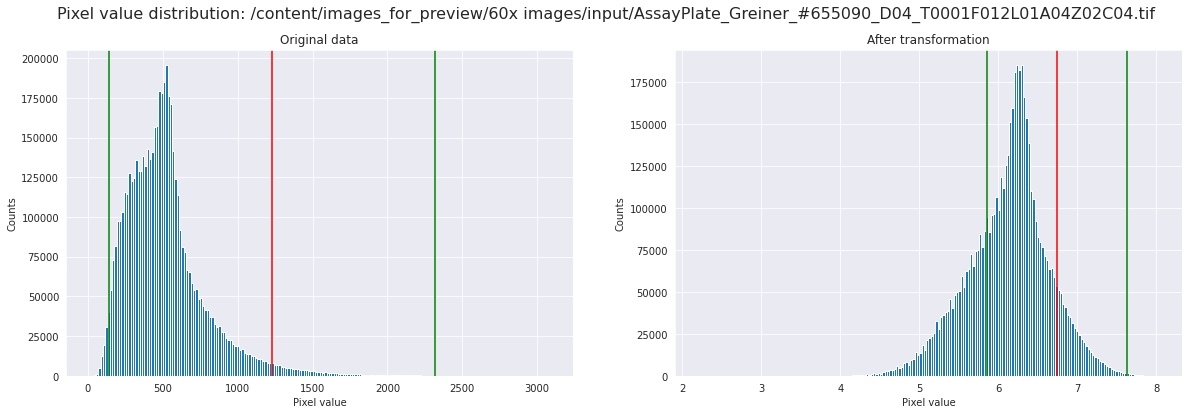

378.4063635628563 486.62929332529995
5.509030090803806 0.8687941890567177


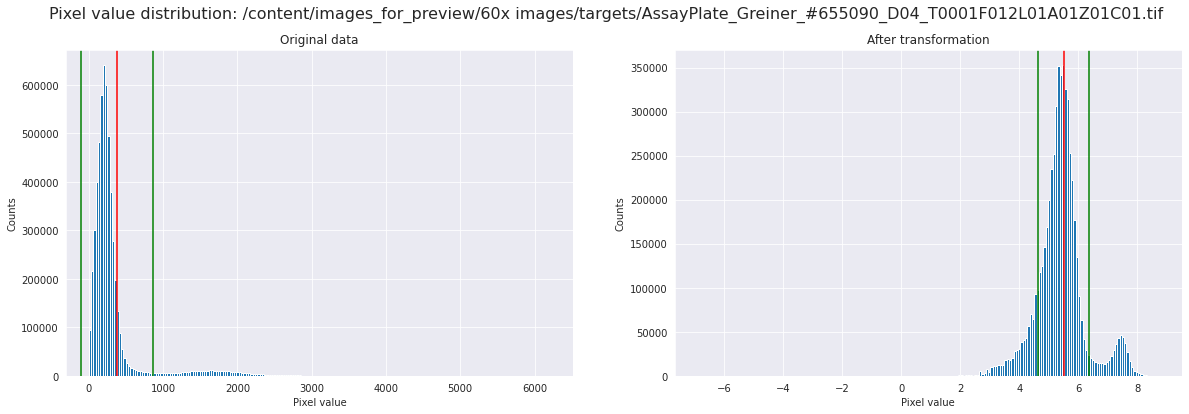

988.0271635755419 898.4957144105855
27.253326 15.661494


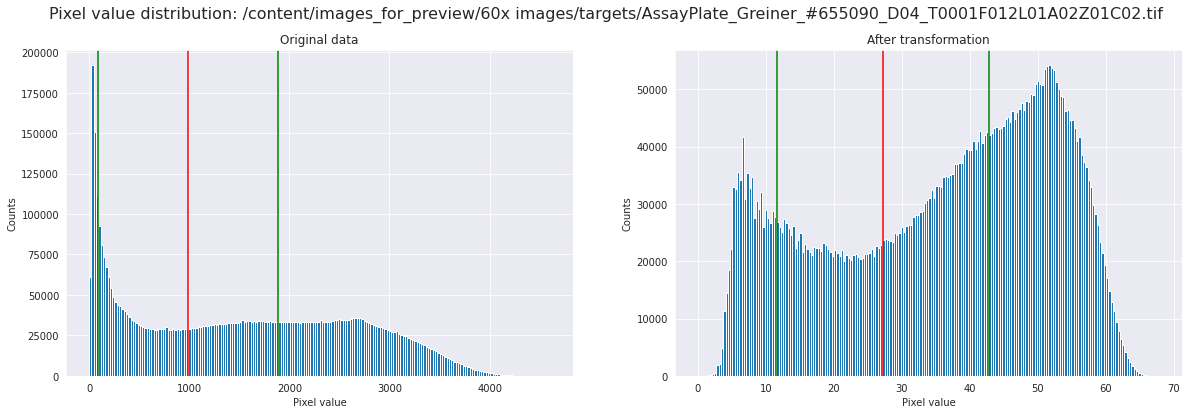

482.04090429532835 254.40286825424363
6.0548612122285075 0.496848062762649


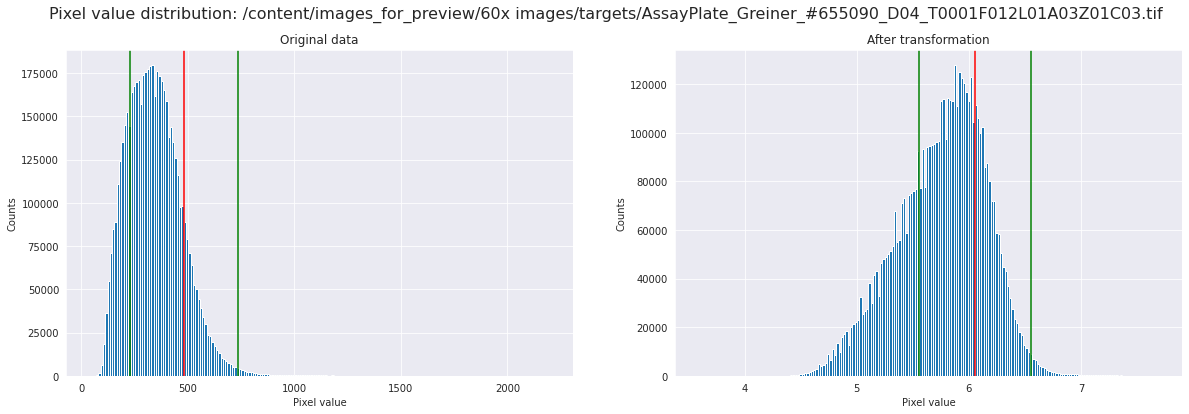

In [13]:
input = glob.glob("/content/images_for_preview/*/input/*") # log
target1 = glob.glob("/content/images_for_preview/*/targets/*A01*")
target2 = glob.glob("/content/images_for_preview/*/targets/*A02*")
target3 = glob.glob("/content/images_for_preview/*/targets/*A03*") # log

def get_mean_and_std(paths, func=None):
    pixel_values = list()
    for i in paths:
        img = cv2.imread(i, -1)
        if func is not None:
            img = func(img)
        pixel_values.append(img.flatten())
    pixel_values = np.concatenate(pixel_values)
    return np.mean(pixel_values), np.std(pixel_values)

def plot_histogram_w_stats(img_path, mean, std, func=None, ax=None):
    img = cv2.imread(img_path, -1)

    if func is not None:
        img = func(img)
    #plt.figure(figsize=(20,6))
    ax.hist(img.ravel(), 200)
    ax.axvline(x=mean,color='red')
    ax.axvline(x=mean+std,color='green')
    ax.axvline(x=mean-std,color='green')
    #plt.show()

def plot_histograms_w_stats(paths, sample_idx=0, transform=None):

    fig, axs = plt.subplots(1,2, figsize=(20,6))
    fig.suptitle(f"Pixel value distribution: {paths[0]}", fontsize=16)
    axs[0].set_title('Original data')
    axs[1].set_title('After transformation')
    axs[0].set_xlabel('Pixel value')
    axs[0].set_ylabel('Counts')
    axs[1].set_xlabel('Pixel value')
    axs[1].set_ylabel('Counts')

    mean, std = get_mean_and_std(paths)
    print(mean, std)
    plot_histogram_w_stats(paths[sample_idx], mean, std, ax=axs[0])

    mean, std = get_mean_and_std(paths, func=transform)
    print(mean, std)
    plot_histogram_w_stats(paths[sample_idx], mean, std, func=transform, ax=axs[1])
    plt.show()
    

log_func = lambda x: np.log(x + 1e-3)

# 1250.8056198505967 1084.9798588268861
# 6.789944517079453 0.8247920659414303 - np.log(x + 1e-3)
plot_histograms_w_stats(input, transform=log_func)

# 378.4063635628563 486.62929332530007
# 5.5090300908038135 0.8687941890567182 - np.log(x + 1e-3)
plot_histograms_w_stats(target1, transform=log_func)

# 988.0271635755419 898.4957144105864
# 27.253351 15.661491 - np.sqrt
plot_histograms_w_stats(target2, transform=np.sqrt)

# 482.04090429532835 254.4028682542436
# 6.054861212228503 0.49684806276264926 - np.log(x + 1e-3)
plot_histograms_w_stats(target3, transform=log_func)


# Creating a PyTorch Dataset and DataLoader for training

In [16]:
def get_image_metadata(path_to_file):
    """Function for extracting metadata from filename of dataset provided by AstraZeneca.
    
    B02   - well (row B, column 02) 
    T0001 - timepoint (irrelevant for this dataset) 
    F001  - field of view = site 
    L01   - timeline (irrelevant for this datset) 
    A01   - action list number (3 fluorescent + 1 brightfield action) 
    Z01   - 3D z-number (slice number or vertical position) 
    C01   - imaging channel (1 nuclear, 2 lipids, 3 cytoplasm, 4 brightfield)
    """
    string_arr = os.path.basename(path_to_file).split("_")
    row_col = string_arr[-2] # Row and column
    timepoint = string_arr[-1][:5]
    fied_of_view = string_arr[-1][5:9]
    timeline = string_arr[-1][9:12]
    action_list_number = string_arr[-1][12:15]
    z_number_3d = string_arr[-1][15:18]
    imaging_channel = string_arr[-1][18:21]
    return {
        "row_col":       row_col,
        #"timepoint":     timepoint,  # apparently irrelevant
        "field of view": fied_of_view,
        #"timeline": timeline,  # apparently irrelevant
        "action_list_number": action_list_number,
        "z_number_3d": z_number_3d,
        "imaging_channel": imaging_channel,
        "path": path_to_file
    }

In [17]:
class ExampleDataset(Dataset):

    def __init__(self, dataset_path, crop_size=(256,256), transform=None):
        """Example dataset for sample images for the Astra Zeneca competition
        
        Group by row_col and field of view
        # row_col
        # field of view
         
        Input and Target share these common values:
        - row_col       = sample id? 
        - field of view = amount of zoom

        For identifying INPUT:
        - action_list_number A04
        - imaging_channel    C04
        - z_number_3d        Z01 - Z07

        For identifying TARGET:
        - action_list_number A01 A02 and A03
        - imaging_channel    C01, C02, C03
        - z_number_3d        Z01
        """
        self.dataset_path = dataset_path
        
        dataset_samples = glob.glob(os.path.join(self.dataset_path, "*/*/*"))
        
        dataset_dicts = [get_image_metadata(path) for path in dataset_samples]
        
        # Group all 7 inputs with all 3 respective targets into variable sample
        samples = dict()
        for sample_dict in dataset_dicts:
            sample_key = (sample_dict["row_col"], sample_dict["field of view"])

            if samples.get(sample_key) is None:
                samples[sample_key] = {
                    "input": dict(),
                    "target": dict()
                }

            if sample_dict["action_list_number"] == "A04": # or sample_dict["imaging_channel"] == "C04"
                # Is an input
                z_number_3d = sample_dict["z_number_3d"]
                samples[sample_key]["input"][z_number_3d] = sample_dict["path"]
            else:
                # Is an target
                action_list_number = sample_dict["action_list_number"]
                samples[sample_key]["target"][action_list_number] = sample_dict["path"]

        self.samples = list(samples.values())
        self.crop_size = crop_size
        self.transforms = transform
        
    def __len__(self):
        #return len(self.samples)
        return 200
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Modulo
        idx = idx % len(self.samples)

        sample_dict = self.samples[idx]

        w, h = cv2.imread(sample_dict["input"]["Z01"], -1).shape
        assert self.crop_size[0] <= w
        assert self.crop_size[1] <= h

        # Select random crop
        c_w, c_h = self.crop_size
        crop_x = np.random.randint(0, w - c_w)
        crop_y = np.random.randint(0, h - c_h)
        #angle = random.uniform(-30, 30) # Random rotation angle

        input = torch.zeros((7, c_w, c_h))
        output = torch.zeros((3, c_w, c_h))
        for i, z_number_3d in enumerate(["Z01", "Z02", "Z03", "Z04", "Z05", "Z06", "Z07"]):
            img_path = sample_dict["input"][z_number_3d]

            #img = ndimage.rotate(Image.open(img_path), angle)
            #img = np.array(img)
            img = cv2.imread(img_path, -1)
            img = img[crop_x:crop_x+c_w, crop_y:crop_y+c_h]

            img = img.astype(np.int32)
            input[i] = torch.Tensor(img)

        for i, action_list_number in enumerate(["A01", "A02", "A03"]):
            img_path = sample_dict["target"][action_list_number]

            #img = ndimage.rotate(Image.open(img_path), angle)
            #img = np.array(img)
            img = cv2.imread(img_path, -1)
            img = img[crop_x:crop_x+c_w, crop_y:crop_y+c_h]

            img = img.astype(np.int32)
            output[i] = torch.Tensor(img)

        if self.transforms:
            for transform in self.transforms:
                input, output = transform(input, output)

        return input, output

x, y = ExampleDataset("/content/images_for_preview/")[0]
print(x.shape, y.shape)

torch.Size([7, 256, 256]) torch.Size([3, 256, 256])


In [19]:
import scipy.ndimage as ndimage
class RandomRotation:
    """Rotate by one of the given angles."""

    def __init__(self, p=0.5, angles=30):
        self.p = p
        self.angles = angles

    def __call__(self, input, output):

        if random.random() < self.p:
            angle = random.uniform(-self.angles, self.angles)
            print(input.size)
            print(input)
            input = ndimage.rotate(input, angle, axes=0, reshape=False)
            output = ndimage.rotate(output, angle, axes=0, reshape=False)

        # more transforms ...
        return input, output

    #def _rotate(self, x, angle):
    #    return torch.from_numpy(ndimage.rotate(x, angle, reshape=False, axes=(1,2)))

class HorizontalFlipping:
    """Flip horizontally."""

    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, input, output):
        if random.random() < self.p:
            input = TF.hflip(input)
            output = TF.hflip(output)
        return input, output

class VerticalFlipping:
    """Flip vertically."""

    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, input, output):
        if random.random() < self.p:
            input = TF.vflip(input)
            output = TF.vflip(output)
        return input, output

class Normalize:
    """Normalize values."""

    def __init__(self, input_stats, output_stats=None):
        self.input_mean, self.input_std = input_stats
        self.output_mean, self.output_std = output_stats

    def __call__(self, input, output):
        input = (input - self.input_mean)/self.input_std
        output = (output - self.output_mean)/self.output_std
        return input, output

class DistributionTransform:
    """Transform distribution to be normally distributed."""

    def __init__(self):
        pass

    def __call__(self, input, output):
        input = torch.log(input + 1e-3)
        output[0] = torch.log(output[0] + 1e-3)
        output[1] = torch.sqrt(output[1])
        output[2] = torch.log(output[2] + 1e-3)
        return input, output

class ToPIL:
    """
    """
    def __init__(self):
        self.to_pil = transforms.ToPILImage()

    def __call__(self, input, output):
        if type(input) == torch.Tensor:
            intput = self.to_pil(input)
        if type(output) == torch.Tensor:
            output = self.to_pil(output)
        
        return input, output

class ToTensor:
    """
    """
    def __init__(self):
        self.to_tensor = transforms.ToTensor()

    def __call__(self, input, output):
        if type(input) == torch.Tensor:
            pass
        else:
            input = self.to_tensor(input)
        if type(output) == torch.Tensor:
            pass
        else:
            output = self.to_tensor(output)
        
        return input, output

rotation_transform = RandomRotation()
hflip_transform = HorizontalFlipping()
vflip_transform = VerticalFlipping()


# Without DistributionTransform
#input_stats = np.array([1250.8056198505967, 1084.9798588268861])
#output_stats = np.array([
#                         [378.4063635628563,  988.0271635755419, 482.04090429532835],
#                         [486.62929332530007, 898.4957144105864, 254.4028682542436]
#                         ])
#output_stats = np.reshape(output_stats, (2,3,1,1))

# With DistributionTransform 
input_stats = np.array([6.789944517079453, 0.8247920659414303])
output_stats = np.array([
                         [5.5090300908038135, 27.253351, 6.054861212228503],
                         [0.8687941890567182, 15.661491, 0.49684806276264926]
                         ])
output_stats = np.reshape(output_stats, (2,3,1,1))

normalize = Normalize(input_stats, output_stats)

dist_transform = DistributionTransform()





data_transforms = A.Compose([
  #ToPIL(),
  #rotation_transform,
  #ToTensor(),
  hflip_transform,
  vflip_transform,
  dist_transform,
  normalize
  ])
x, y = ExampleDataset("/content/images_for_preview/", transform=data_transforms)[0]
print(x.shape, y.shape)
print(x.mean())
print(y.mean())

def post_process(target):
    output_stats = torch.Tensor([
                         [5.5090300908038135, 27.253351, 6.054861212228503],
                         [0.8687941890567182, 15.661491, 0.49684806276264926]
                         ]).float()
    output_stats = output_stats.view(2,1,3,1,1)
    # (batch, channel, width, height)
    target = target*output_stats[1] + output_stats[0]

    target[:,0] = torch.exp(target[:,0]) - 1e-3
    target[:,1] = target[:,1]**2
    target[:,2] = torch.exp(target[:,2]) - 1e-3
    return target.float()


torch.Size([7, 256, 256]) torch.Size([3, 256, 256])
tensor(-0.7544)
tensor(0.0337, dtype=torch.float64)


## Test: COnfirm Dataset is working

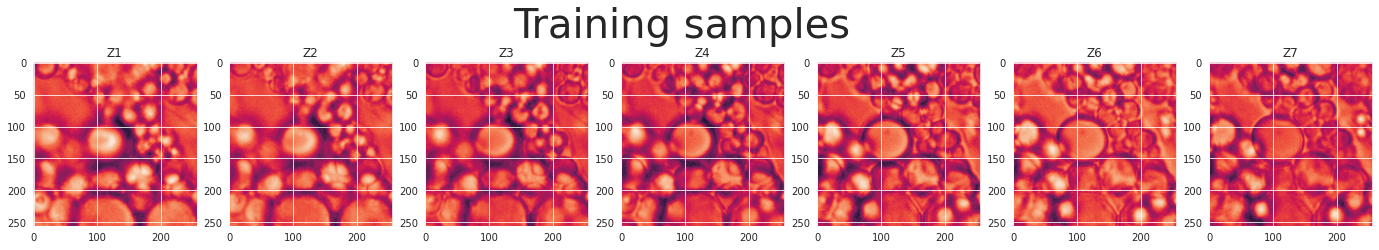

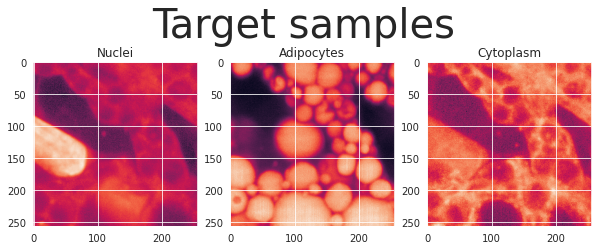

In [30]:
# Confirm that Dataset is working
fig, ax = plt.subplots(1,7, figsize=(24,4))
fig.suptitle("Training samples", fontsize=40)
names = ["Z1", "Z2", "Z3", "Z4", "Z5", "Z6", "Z7"]
for i, x_sample in enumerate(x):
    ax[i].set_title(names[i])
    ax[i].imshow(x_sample)

fig, ax = plt.subplots(1,3, figsize=(10,4))
fig.suptitle("Target samples", fontsize=40)
names = ["Nuclei", "Adipocytes", "Cytoplasm"]
for i, x_sample in enumerate(y):
    ax[i].imshow(x_sample)
    ax[i].set_title(names[i])

In [ ]:
dataset = ExampleDataset("/content/images_for_preview/", transform=data_transforms)
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=0)
x, y = next(iter(dataloader))
print(x.shape, y.shape)

torch.Size([32, 7, 256, 256]) torch.Size([32, 3, 256, 256])


# Training with UNet

To use UNet, we do the following
1. Obtain pretrained UNet model
2. Change input layer to fit 7 channels
3. Change output layer to output 3 channels

In [ ]:
class UNet(nn.Module):
    """
    https://github.com/milesial/Pytorch-UNet
    """
    def __init__(self, input_channels=7, output_channels=3):
        super(UNet, self).__init__()

        # Get model from PyTorch hub
        net = torch.hub.load('milesial/Pytorch-UNet', 'unet_carvana')

        # Configure input layer to take 7 channels
        net.inc.double_conv[0] = nn.Conv2d(
            input_channels, 
            net.inc.double_conv[0].out_channels, 
            kernel_size = net.inc.double_conv[0].kernel_size, 
            stride = net.inc.double_conv[0].stride, 
            padding = net.inc.double_conv[0].padding
            )

        # Configure output layer to output 3 channels
        net.outc.conv = nn.Conv2d(
            net.outc.conv.in_channels,
            output_channels,
            kernel_size = net.outc.conv.kernel_size,
            stride = net.outc.conv.stride
        )
        self.net = net
    
    def forward(self, x):
        return self.net(x)


# Test inference
model = UNet()
#model.eval()
#pred = model(x)
#print(pred.shape)

Using cache found in /root/.cache/torch/hub/milesial_Pytorch-UNet_master


# PyTorch training loop

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
epochs = 100
global_step = 0
save_cp = False
device = "cuda:0" if torch.cuda.is_available() else "cpu"

model.to(device)
all_A1_train_losses = list()
all_A2_train_losses = list()
all_A3_train_losses = list()
for epoch in range(epochs):
        model.train()

        epoch_loss = 0
        A1_train_losses = list()
        A2_train_losses = list()
        A3_train_losses = list()
        with tqdm(total=len(dataset), desc=f'Epoch {epoch + 1}/{epochs}', unit='img') as pbar:
            for inputs, targets in dataloader:

                inputs = inputs.to(device=device, dtype=torch.float32)
                targets = targets.to(device, dtype=torch.float32)
                
                assert not torch.isnan(inputs).any()  # Input
                assert not torch.isnan(targets).any() # targets
                preds = model(inputs)
                assert not torch.isnan(preds).any() # preds
                loss = criterion(preds, targets)
                epoch_loss += loss.item()

                

                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_value_(model.parameters(), 0.1)
                optimizer.step()

                global_step += 1
                pred = post_process(preds.detach().cpu())
                targets = post_process(targets.cpu())
                comp_loss_A1 = criterion(pred[:,0], targets[:,0]).item()
                comp_loss_A2 = criterion(pred[:,1], targets[:,1]).item()
                comp_loss_A3 = criterion(pred[:,2], targets[:,2]).item()
 
                A1_train_losses.append(comp_loss_A1)
                A2_train_losses.append(comp_loss_A2)
                A3_train_losses.append(comp_loss_A3)
                pbar.set_postfix(**{'loss (batch)': loss.item(), "A1": np.mean(A1_train_losses), "A2": np.mean(A2_train_losses), "A3": np.mean(A3_train_losses)})
                pbar.update(inputs.shape[0])
                #if global_step % (len(dataset) // (10 * batch_size)) == 0:
                #    for tag, value in model.named_parameters():
                #        tag = tag.replace('.', '/')
                #    val_score = eval_net(model, val_loader, device)
                #    scheduler.step(val_score)
                #
                #    if model.n_classes > 1:
                #        logging.info('Validation cross entropy: {}'.format(val_score))
                #    else:
                #        logging.info('Validation Dice Coeff: {}'.format(val_score))
        all_A1_train_losses.append(np.mean(A1_train_losses))
        all_A2_train_losses.append(np.mean(A2_train_losses))
        all_A3_train_losses.append(np.mean(A3_train_losses))
        if save_cp:
            try:
                os.mkdir(dir_checkpoint)
                logging.info('Created checkpoint directory')
            except OSError:
                pass
            torch.save(net.state_dict(),
                       dir_checkpoint + f'CP_epoch{epoch + 1}.pth')
            logging.info(f'Checkpoint {epoch + 1} saved !')


In [ ]:
plt.plot(all_A1_train_losses)
plt.plot(all_A2_train_losses)
plt.plot(all_A3_train_losses)

In [ ]:
# Confirm that Dataset is working
x, y = ExampleDataset("/content/images_for_preview/", transform=data_transforms)[0]

fig, ax = plt.subplots(1,7, figsize=(24,15))
for i, x_sample in enumerate(x):
    ax[i].imshow(x_sample)

fig, ax = plt.subplots(1,3, figsize=(10,6))
for i, x_sample in enumerate(y):
    ax[i].imshow(x_sample)

model.eval().to(device)
preds = model(x.unsqueeze(0).to(device)).cpu()
fig, ax = plt.subplots(1,3, figsize=(10,6))
for i, x_sample in enumerate(preds[0]):
    ax[i].imshow(x_sample.detach().numpy())